In [35]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import pickle
import os

2024-02-06 01:04:38.174690: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 01:04:38.994228: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 01:04:38.994282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 01:04:39.019232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 01:04:39.200017: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 01:04:39.201119: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
# Read the training data from CSV files
training_raw_df = pd.read_csv('target_train.csv')
pharmacy_raw_df = pd.read_csv('rxclms_train.csv')
med_raw_df = pd.read_csv('medclms_train.csv')

In [4]:
# Pharmacy Data Processing

# Replace values in the pharmacy dataframe
pharmacy_raw_df.columns
value_mapping = {"N": 0, "Y": 1}
pharmacy_raw_df = pharmacy_raw_df.replace(value_mapping)

# Extract the first part of 'therapy_id' to create a new 'id' column
pharmacy_raw_df['id'] = pharmacy_raw_df['therapy_id'].str.split('-').str[0]

# Fill NaN values with 0 and drop 'therapy_id' column
pharmacy_raw_df = pharmacy_raw_df.fillna(0)
pharmacy_raw_df = pharmacy_raw_df.drop(columns=['therapy_id'])

# Replace values in the 'maint_ind' column
value_mapping = {"NONMAINT": 0, "MAINT": 1}
pharmacy_raw_df = pharmacy_raw_df.replace(value_mapping)

# Define columns of interest in the pharmacy dataframe
pharmacy_columns = ['id', "pay_day_supply_cnt", "rx_cost", "tot_drug_cost_accum_amt", "reversal_ind", "mail_order_ind",
                    "generic_ind", "maint_ind", "ddi_ind", "anticoag_ind", "diarrhea_treat_ind", "nausea_treat_ind", "seizure_treat_ind"]

# Group by 'id' and aggregate pharmacy data
pharmacy_df = pharmacy_raw_df[pharmacy_columns].groupby('id').agg({
    'pay_day_supply_cnt': 'mean',
    'rx_cost': 'mean',
    'tot_drug_cost_accum_amt': 'sum',
    'reversal_ind': 'max',
    'mail_order_ind': 'max',
    'generic_ind': 'max',
    'maint_ind': 'max',
    'ddi_ind': 'max',
    'anticoag_ind': 'max',
    'diarrhea_treat_ind': 'max',
    'nausea_treat_ind': 'max',
    'seizure_treat_ind': 'max'
})

# Reset index and convert 'id' to string
pharmacy_df.reset_index(inplace=True)
pharmacy_df['id'] = pharmacy_df['id'].astype(str)
training_raw_df['id'] = training_raw_df['id'].astype(str)

# Replace values in the 'generic' column
value_mapping = {"GENERIC": 0, "BRANDED": 1}
pharmacy_df = pharmacy_df.replace(value_mapping)

# Merge pharmacy data with training data
therapy_pharm = training_raw_df.merge(pharmacy_df, on='id', how='left')
therapy_pharm

,id,therapy_id,therapy_start_date,therapy_end_date,tgt_ade_dc_ind,race_cd,est_age,sex_cd,cms_disabled_ind,cms_low_income_ind,...,tot_drug_cost_accum_amt,reversal_ind,mail_order_ind,generic_ind,maint_ind,ddi_ind,anticoag_ind,diarrhea_treat_ind,nausea_treat_ind,seizure_treat_ind
0,1005597228,1005597228-TAGRISSO-1,2020-03-11T00:00:00.000+0000,2020-09-07,0,1.0,NaN,NaN,NaN,NaN,...,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,1005964858,1005964858-TAGRISSO-1,2021-08-23T00:00:00.000+0000,2021-09-22,1,1.0,86.0,M,0.0,0.0,...,100553.85,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1007548572,1007548572-TAGRISSO-1,2022-01-17T00:00:00.000+0000,2022-07-16,0,1.0,79.0,F,0.0,1.0,...,20645340.56,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1009508044,1009508044-TAGRISSO-1,2020-01-23T00:00:00.000+0000,2020-07-21,0,1.0,70.0,F,1.0,1.0,...,3564289.68,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1028064791,1028064791-TAGRISSO-1,2021-02-23T00:00:00.000+0000,2021-08-22,0,2.0,74.0,F,1.0,1.0,...,1136766.79,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,1005265852,1005265852-TAGRISSO-1,2022-01-18T00:00:00.000+0000,2022-05-01,1,5.0,91.0,F,0.0,0.0,...,279494.52,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1228,1017236720,1017236720-TAGRISSO-1,2019-09-10T00:00:00.000+0000,2020-03-08,0,1.0,79.0,M,0.0,0.0,...,1156699.27,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1229,1059781692,1059781692-TAGRISSO-1,2020-03-10T00:00:00.000+0000,2020-09-06,0,4.0,81.0,F,0.0,1.0,...,868091.21,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1230,1106680931,1106680931-TAGRISSO-1,2021-03-01T00:00:00.000+0000,2021-03-31,0,1.0,50.0,M,1.0,0.0,...,31783.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Medical Data Processing

# Extract the first part of 'therapy_id' to create a new 'id' column and drop 'therapy_id'
med_raw_df['id'] = med_raw_df['therapy_id'].str.split('-').str[0]
med_raw_df = med_raw_df.drop(columns=['therapy_id'])

# Define columns related to diagnosis
med_raw_df.columns
diag_columns = ['id', 'primary_diag_cd', 'diag_cd2', 'diag_cd3', 'diag_cd4', 'diag_cd5', 'diag_cd6', 'diag_cd7',
                'diag_cd8', 'diag_cd9']
diag_columns_wid = ['primary_diag_cd', 'diag_cd2', 'diag_cd3', 'diag_cd4', 'diag_cd5', 'diag_cd6', 'diag_cd7',
                    'diag_cd8', 'diag_cd9']

# Extract first letters of diagnosis codes in specific columns
med_diag = med_raw_df[diag_columns]
med_diag[diag_columns_wid] = med_diag[diag_columns_wid].apply(lambda x: x.str[0])
med_diag

# Update original dataframe with modified diagnosis columns
med_raw_df[diag_columns] = med_diag

# Define columns of interest in the medical dataframe
med_columns = ['id', 'primary_diag_cd', 'diag_cd2', 'diag_cd3', 'diag_cd4', 'diag_cd5', 'diag_cd6', 'diag_cd7',
               'diag_cd8', 'diag_cd9', 'ade_diagnosis', 'seizure_diagnosis', 'pain_diagnosis', 'fatigue_diagnosis',
               'nausea_diagnosis', 'hyperglycemia_diagnosis', 'constipation_diagnosis', 'diarrhea_diagnosis']

# Group by 'id' and aggregate medical data
med_df = med_raw_df[med_columns].groupby('id').agg({
    'primary_diag_cd': 'sum',
    'diag_cd2': 'sum',
    'diag_cd3': 'sum',
    'diag_cd4': 'sum',
    'diag_cd5': 'sum',
    'diag_cd6': 'sum',
    'diag_cd7': 'sum',
    'diag_cd8': 'sum',
    'diag_cd9': 'sum',
    'ade_diagnosis': 'max',
    'seizure_diagnosis': 'max',
    'pain_diagnosis': 'max',
    'fatigue_diagnosis': 'max',
    'nausea_diagnosis': 'max',
    'hyperglycemia_diagnosis': 'max',
    'constipation_diagnosis': 'max',
    'diarrhea_diagnosis': 'max'
})

# Reset index and convert 'id' to string
med_df.reset_index(inplace=True)
pharmacy_df['id'] = pharmacy_df['id'].astype(str)
med_df['id'] = med_df['id'].astype(str)

# Process and update diagnosis columns with sets of letters
med_df[diag_columns_wid] = med_df[diag_columns_wid].apply(lambda x: x.apply(lambda y: set(str(y))))
med_df

# Extract letters from diagnosis columns
diag_letters = med_df[diag_columns_wid]
diag_letters

/tmp/ipykernel_101/3229647608.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  med_diag[diag_columns_wid] = med_diag[diag_columns_wid].apply(lambda x: x.str[0])


,primary_diag_cd,diag_cd2,diag_cd3,diag_cd4,diag_cd5,diag_cd6,diag_cd7,diag_cd8,diag_cd9
0,"{I, C, Z, G, M, R}","{D, J, C, N, Z, I, G, M, R}","{D, J, C, I, F, E, M, R}","{I, Z, C, N, E, R}","{I, C, G, E, R}","{G, E, M, I}","{Z, E, M, K, R}","{Z, E, M}",{Z}
1,"{C, I, E, M, K, R}","{D, I, Z, N, C, E, F, K, B, R}","{N, C, I, Z, E, K, R}","{D, N, C, I, M, K}","{D, I, Z, F, K}","{C, I, G, E, F, R}","{D, I, G, M, K}","{Z, F, M, I}","{I, Z, N, F, K}"
2,"{J, N, C, I, M, A, R}","{J, C, Z, N, I, M, R}","{L, D, J, C, Z, I, M, R}","{J, C, I, N, M, A, R}","{R, I, J, C}","{J, C, Z, I, M}","{F, J, C}","{Z, I, J, N}","{Z, J}"
3,"{C, Z, E, H, R}","{Z, E, C}","{N, C}","{E, C}","{Z, C}","{G, E}","{T, N}","{E, R}",{R}
4,"{D, J, C, I, G, F, E, R}","{J, N, C, G, R}","{D, J, C, Z, R}","{E, D, R}","{T, C}","{E, R}",{R},"{D, K}","{E, K}"
...,...,...,...,...,...,...,...,...,...
531,"{E, D, C}","{D, R, C}","{D, C, Z, E, K, R}","{L, D, C, Z, M, R}","{Z, C, K}","{Z, E}",{Z},{Z},{Z}
532,{C},{Z},{0},{0},{0},{0},{0},{0},{0}
533,"{J, I, Z, C, R}","{D, N, Z, C, I, R}","{L, J, C, Z, G, M}","{J, Z, T, G, M, R}","{Z, E, L, I}","{Z, G, T}","{D, N, Z, G, E}","{Z, L}",{Z}
534,"{N, Z, C, H, R}","{Z, G, H, C}","{C, Z, E, M, H}","{N, Z, C, M, H}","{Z, E, H}","{Z, H, C}","{Z, H}",{0},{0}


In [6]:
# Processing Diagnoses Letters and Concatenation

# Copy the DataFrame for processing letters
df = diag_letters.copy()

# Create columns for each letter of the alphabet
letters = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

# Set initial values for each letter
for letter in letters:
    df[letter] = 0

# Iterate over each letter and update the corresponding column in the DataFrame
for letter in letters:
    for column in diag_letters.columns:
        df[letter] = diag_letters.apply(lambda row: any(letter in cell for cell in row), axis=1).astype(int)

# Drop the original diagnosis columns
df = df.drop(columns=diag_columns_wid)
print(df)

# Concatenate the new DataFrame with the medical data DataFrame
med_df = pd.concat([med_df, df], axis=1)
med_df.drop(columns=diag_columns_wid)

     A  B  C  D  E  F  G  H  I  J  ...  Q  R  S  T  U  V  W  X  Y  Z
0    0  0  1  1  1  1  1  0  1  1  ...  0  1  0  0  0  0  0  0  0  1
1    0  1  1  1  1  1  1  0  1  0  ...  0  1  0  0  0  0  0  0  0  1
2    1  0  1  1  0  1  0  0  1  1  ...  0  1  0  0  0  0  0  0  0  1
3    0  0  1  0  1  0  1  1  0  0  ...  0  1  0  1  0  0  0  0  0  1
4    0  0  1  1  1  1  1  0  1  1  ...  0  1  0  1  0  0  0  0  0  1
..  .. .. .. .. .. .. .. .. .. ..  ... .. .. .. .. .. .. .. .. .. ..
531  0  0  1  1  1  0  0  0  0  0  ...  0  1  0  0  0  0  0  0  0  1
532  0  0  1  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  1
533  0  0  1  1  1  0  1  0  1  1  ...  0  1  0  1  0  0  0  0  0  1
534  0  0  1  0  1  0  1  1  0  0  ...  0  1  0  0  0  0  0  0  0  1
535  0  0  1  1  0  0  0  1  1  1  ...  0  0  0  0  0  0  0  0  0  1

[536 rows x 26 columns]


,id,ade_diagnosis,seizure_diagnosis,pain_diagnosis,fatigue_diagnosis,nausea_diagnosis,hyperglycemia_diagnosis,constipation_diagnosis,diarrhea_diagnosis,A,...,Q,R,S,T,U,V,W,X,Y,Z
0,1000110916,1,0,0,0,1,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1
1,1000207687,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,1000260673,1,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
3,1000767323,1,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,1
4,1000767683,1,0,0,1,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,1121093945,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
532,1121210255,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
533,1121906962,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
534,1121951424,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [7]:
# Merging and Preprocessing

# Merge dataframes
therapy_pharm_med = therapy_pharm.merge(med_df, on='id', how='left')
raw_df = therapy_pharm_med.copy()

# One-hot encode 'sex_cd'
raw_df = pd.get_dummies(raw_df, columns=['sex_cd'], prefix='sex')

# Duplicate removal
dedup_df = raw_df.copy()

# Count duplicates based on 'id'
duplicate_counts = dedup_df['id'].value_counts()
print(duplicate_counts)

1005597228    1
1110192822    1
1065489643    1
1062050295    1
1030416128    1
             ..
1087199406    1
1082029303    1
1071895245    1
1035181572    1
1117477435    1
Name: id, Length: 1232, dtype: int64


In [12]:
# Dealing with missing values

# Copy the DataFrame to avoid modifying the original
fill_na = raw_df.copy()

# Define the mapping of values
value_mapping = {np.nan: np.nan, 0.0: "False", 1.0: "True"}
fill_na[["cms_disabled_ind","cms_low_income_ind"]] = fill_na[["cms_disabled_ind","cms_low_income_ind"]].replace(value_mapping)
fill_na.fillna(np.nan, inplace=True)
fill_na

# Fill missing values for 'est_age' with mean
fill_na['est_age'].fillna(fill_na['est_age'].mean(), inplace=True)

# Fill categorical variables with mode
columns_to_fill_mode = ['cms_disabled_ind', 'cms_low_income_ind', 'sex_F', 'sex_M', 'ade_diagnosis', 'seizure_diagnosis',
                         'pain_diagnosis', 'fatigue_diagnosis', 'nausea_diagnosis', 'hyperglycemia_diagnosis',
                         'constipation_diagnosis', 'reversal_ind', 'mail_order_ind', 'generic_ind', 'maint_ind', 'ddi_ind',
                         'anticoag_ind', 'diarrhea_treat_ind', 'nausea_treat_ind', 'seizure_treat_ind', 'ade_diagnosis',
                         'seizure_diagnosis', 'diarrhea_diagnosis']

for column in columns_to_fill_mode:
    fill_na[column].fillna(fill_na[column].mode().iloc[0], inplace=True)

# Fill numerical variable 'race_cd' with mean
fill_na['race_cd'].fillna(fill_na['race_cd'].mean(), inplace=True)

# Function to fill remaining columns with mean
def fill_columns_with_mean(df):
    letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for letter in letters:
        column_name = letter
        if column_name in df.columns:
            column_mean = round(df[column_name].mean())
            df[column_name].fillna(column_mean, inplace=True)

fill_columns_with_mean(fill_na)

# Check for remaining NaN values
nan_count = fill_na.isna().sum()
print(nan_count)

id                    0
therapy_id            0
therapy_start_date    0
therapy_end_date      0
tgt_ade_dc_ind        0
                     ..
X                     0
Y                     0
Z                     0
sex_F                 0
sex_M                 0
Length: 66, dtype: int64


In [17]:
# Data preprocessing

# Copy the DataFrame for further modifications
target_train = fill_na.copy()

# Map categorical values to numerical values
value_mapping = {"False": 0, "True": 1}
target_train = target_train.replace(value_mapping)

# Map binary values to 0 and 1
value_mapping = {False: 0, True: 1}
s = ['sex_F','sex_M']
target_train[s] = target_train[s].replace(value_mapping)

# Drop unnecessary columns
columns_to_remove = ['tgt_ade_dc_ind','id','therapy_id','therapy_start_date','therapy_end_date']
target_train = target_train.drop(columns=diag_columns_wid)

# Create binary columns for race
modified_tt = target_train.copy()
race_key = {
    0: 'Unknown',
    1: 'White',
    2: 'Black',
    3: 'Other',
    4: 'Asian',
    5: 'Hispanic',
    6: 'Native American'
}

# Create a binary column for each race, and set them all to 0 initially
for index, race in race_key.items():
    modified_tt[race] = 0

# Iterate through the DataFrame and set the appropriate race column to 1 based on 'race_cd'
for index, row in modified_tt.iterrows():
    race_cd = row['race_cd']
    if race_cd in race_key:
        modified_tt.at[index, race_key[race_cd]] = 1
    else:
        modified_tt.at[index, 'Unknown'] = 1

# Drop the original 'race_cd' column
modified_tt = modified_tt.drop(columns=['race_cd'])

# Update the target_train DataFrame
target_train = modified_tt.copy()
print(target_train)

# Log-transform numerical columns
target_train['rx_cost'] = np.log10(target_train['rx_cost'] + 10)
target_train['tot_drug_cost_accum_amt'] = np.log10(target_train['tot_drug_cost_accum_amt'] + 1000)

              id             therapy_id            therapy_start_date  \
0     1005597228  1005597228-TAGRISSO-1  2020-03-11T00:00:00.000+0000   
1     1005964858  1005964858-TAGRISSO-1  2021-08-23T00:00:00.000+0000   
2     1007548572  1007548572-TAGRISSO-1  2022-01-17T00:00:00.000+0000   
3     1009508044  1009508044-TAGRISSO-1  2020-01-23T00:00:00.000+0000   
4     1028064791  1028064791-TAGRISSO-1  2021-02-23T00:00:00.000+0000   
...          ...                    ...                           ...   
1227  1005265852  1005265852-TAGRISSO-1  2022-01-18T00:00:00.000+0000   
1228  1017236720  1017236720-TAGRISSO-1  2019-09-10T00:00:00.000+0000   
1229  1059781692  1059781692-TAGRISSO-1  2020-03-10T00:00:00.000+0000   
1230  1106680931  1106680931-TAGRISSO-1  2021-03-01T00:00:00.000+0000   
1231  1117477435  1117477435-TAGRISSO-1  2021-10-04T00:00:00.000+0000   

     therapy_end_date  tgt_ade_dc_ind    est_age  cms_disabled_ind  \
0          2020-09-07               0  73.771976     

In [29]:
# Fill missing values in specific columns
X['pay_day_supply_cnt'].fillna(X['pay_day_supply_cnt'].mean(), inplace=True)
X['rx_cost'].fillna(X['rx_cost'].mean(), inplace=True)
X['tot_drug_cost_accum_amt'].fillna(X['tot_drug_cost_accum_amt'].mean(), inplace=True)

# Drop any remaining rows with NaN values
X = X.dropna()

nan_count = X.isna().sum()
print(nan_count)

est_age                    0
cms_disabled_ind           0
cms_low_income_ind         0
pay_day_supply_cnt         0
rx_cost                    0
tot_drug_cost_accum_amt    0
reversal_ind               0
mail_order_ind             0
generic_ind                0
maint_ind                  0
ddi_ind                    0
anticoag_ind               0
diarrhea_treat_ind         0
nausea_treat_ind           0
seizure_treat_ind          0
ade_diagnosis              0
seizure_diagnosis          0
pain_diagnosis             0
fatigue_diagnosis          0
nausea_diagnosis           0
hyperglycemia_diagnosis    0
constipation_diagnosis     0
diarrhea_diagnosis         0
A                          0
B                          0
C                          0
D                          0
E                          0
F                          0
G                          0
H                          0
I                          0
J                          0
K                          0
L             

In [30]:
# Feature selection

# Apply SelectKBest class to extract top 10 best features using chi-squared test
bestfeatures = SelectKBest(score_func=chi2, k=11)
fit = bestfeatures.fit(X, y)

# Get feature scores and names
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']

# Print 10 best features
print(featureScores.nlargest(11, 'Score'))

# Select top 11 features
features = featureScores.nlargest(11, 'Score')
cols = features['Specs']
X = X[cols]
X.columns

                     Specs       Score
18       fatigue_diagnosis  165.410235
19        nausea_diagnosis  147.563916
21  constipation_diagnosis   94.226290
41                       S   78.544364
28                       F   64.156708
22      diarrhea_diagnosis   63.193673
24                       B   42.795040
34                       L   35.844881
23                       A   34.928341
45                       W   32.671497
42                       T   30.627002


Index(['fatigue_diagnosis', 'nausea_diagnosis', 'constipation_diagnosis', 'S',
       'F', 'diarrhea_diagnosis', 'B', 'L', 'A', 'W', 'T'],
      dtype='object')

8/8 [==============================] - 0s 1ms/step
AUC (alpha=0.01): 0.9304733727810651
              precision    recall  f1-score   support

           0       0.99      0.78      0.88       221
           1       0.34      0.96      0.51        26

    accuracy                           0.80       247
   macro avg       0.67      0.87      0.69       247
weighted avg       0.93      0.80      0.84       247



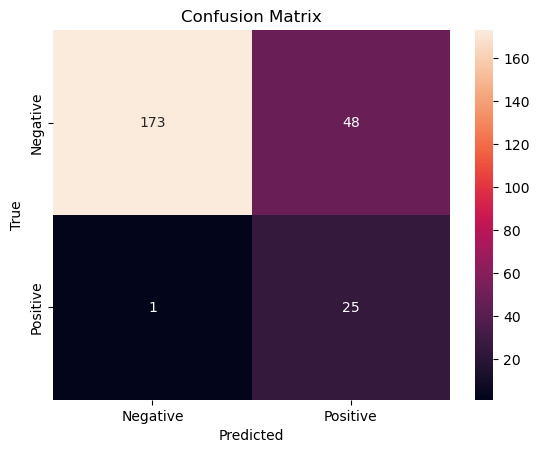

Percentages:
True Positive: 10.12%
False Positive: 19.43%
True Negative: 70.04%
False Negative: 0.40%
8/8 [==============================] - 0s 1ms/step


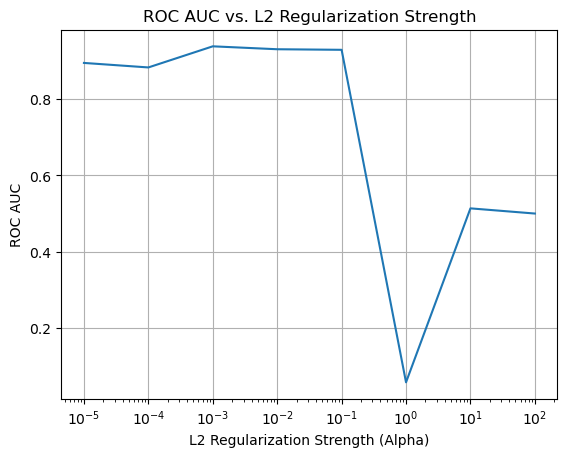

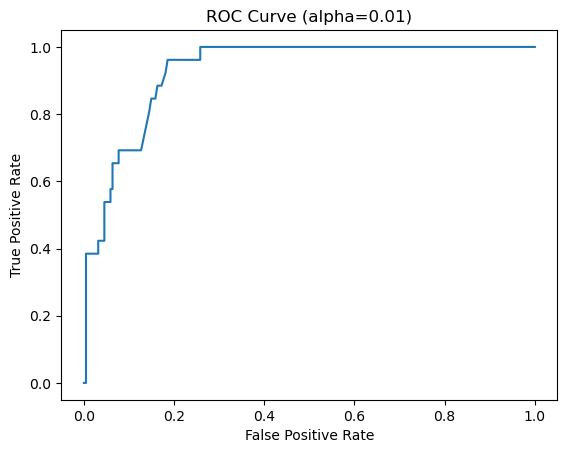

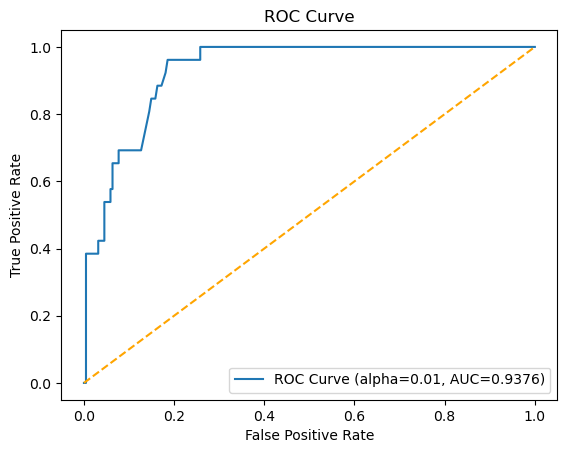

In [37]:
# Neural Network Model

# Define a directory to save the models
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

# Initialize variables to store ROC curve data for alpha=0.01
fpr_alpha_0_01, tpr_alpha_0_01, thresholds_alpha_0_01 = None, None, None

# Load your data
X = target_train.drop(columns=['tgt_ade_dc_ind', 'id', 'therapy_id', 'therapy_start_date', 'therapy_end_date'])
y = target_train['tgt_ade_dc_ind']

cols = features['Specs']
X = X[cols]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a range of L2 regularization strengths (alphas) to test
alphas = np.logspace(-5, 2, 8)

# Create empty lists to store ROC AUC values for each alpha
roc_auc_values = []

# Class weights for imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Iterate over different L2 regularization strengths
for alpha in alphas:

    model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(alpha)),
        layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(alpha)),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the neural network
    model_final = model.fit(X_train, y_train, epochs=15, batch_size=64, verbose=0,
                            validation_data=(X_val, y_val), class_weight=class_weight_dict)

    # Make predictions on the validation set
    y_pred = model.predict(X_val)

    # Calculate and store ROC AUC
    auc = roc_auc_score(y_val, y_pred)
    roc_auc_values.append(auc)

    if alpha == 0.01:
        # Calculate the fpr and tpr for the ROC curve
        y_val_final = y_val
        y_pred_final = y_pred
        fpr_alpha_0_01, tpr_alpha_0_01, thresholds_alpha_0_01 = roc_curve(y_val, y_pred)

        # Save the model to a file
        model_filename = os.path.join(model_dir, 'model_alpha_0.01.keras')
        model.save(model_filename)

        # Save other relevant data
        model_data = {
            'alphas': alphas,
            'roc_auc_values': roc_auc_values,
            'fpr_alpha_0_01': fpr_alpha_0_01,
            'tpr_alpha_0_01': tpr_alpha_0_01,
            'thresholds_alpha_0_01': thresholds_alpha_0_01,
        }
        model_data_filename = os.path.join(model_dir, 'model_data_alpha_0.01.keras')
        with open(model_data_filename, 'wb') as file:
            pickle.dump(model_data, file)

        # Print AUC and classification report
        print(f"AUC (alpha={alpha}): {auc}")
        y_pred_binary = (y_pred > 0.5).astype(int)
        print(classification_report(y_val, y_pred_binary))
        
        # Create a confusion matrix
        conf_matrix = confusion_matrix(y_val, y_pred_binary)
        
        # Visualize the confusion matrix
        labels = ['Negative', 'Positive']  # Assuming binary classification (0 and 1)
        sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        # Calculate percentages from the confusion matrix
        tn, fp, fn, tp = conf_matrix.ravel()
        total_samples = tn + fp + fn + tp

        percentages = {
            'True Positive': (tp / total_samples) * 100,
            'False Positive': (fp / total_samples) * 100,
            'True Negative': (tn / total_samples) * 100,
            'False Negative': (fn / total_samples) * 100
        }

        print("Percentages:")
        for label, percentage in percentages.items():
            print(f"{label}: {percentage:.2f}%")

        if alpha == 0.01:
            # Save confusion matrix for alpha=0.01
            conf_matrix_alpha_0_01 = conf_matrix

# Plot the ROC AUC values
plt.plot(alphas, roc_auc_values, linestyle='-')
plt.xlabel("L2 Regularization Strength (Alpha)")
plt.ylabel("ROC AUC")
plt.title("ROC AUC vs. L2 Regularization Strength")
plt.xscale("log")
plt.grid()

# Show the plot for alpha=0.01
if fpr_alpha_0_01 is not None and tpr_alpha_0_01 is not None:
    plt.figure()
    plt.plot(fpr_alpha_0_01, tpr_alpha_0_01)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (alpha=0.01)')
    plt.show()

# Plot the ROC curve for alpha=0.01
if fpr_alpha_0_01 is not None and tpr_alpha_0_01 is not None:
    plt.figure()
    plt.plot(fpr_alpha_0_01, tpr_alpha_0_01, label='ROC Curve (alpha=0.01, AUC=0.9376)')
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


In [ ]:
# Prediction on New Data

final_data = data.drop(columns=['id', 'therapy_id'])
final_data = final_data[cols]
final_data = scaler.transform(final_data)

# Define the path to the directory where the model is saved
model_dir = 'saved_models'

# Load the model for alpha=0.01
model_filename = os.path.join(model_dir, 'model_alpha_0.01.keras')
loaded_model = keras.models.load_model(model_filename)

y_pred_new = loaded_model.predict(final_data)
y_pred_prob_flat = y_pred_new.flatten()

In [ ]:
# Save results

# Create a DataFrame for results
results_df = pd.DataFrame({
    'ID': data['id'],
    'SCORE': y_pred_prob_flat
})
results_df = results_df.sort_values(by='SCORE', ascending=False)
results_df['RANK'] = range(1, len(results_df) + 1)
print(results_df)
results_df.style.format("{:.f}")

# Save results to CSV
results_df.to_csv("results.csv", index=False)

# Save binary results to CSV for additional analysis or visualization
results_df_graphs = pd.DataFrame({
    'id': data['id'],
    'SCORE': (y_pred_new > 0.5).astype(int).flatten()
})
results_df_graphs.to_csv("results_df_graphs.csv", index=False)